**Name: Krish Murjani | N Number: N10121101 | NetID: km6520**

### **AI CS-GY-6613 Assignment 1B**

# **Optimization algorithms for linear regression**

# **Task 1: Stochastic Gradient Descent** 

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [29]:
# create the dataset 
def generate_toy_data(func, size, noise, interval=[0, 1]):
    x_vals = torch.linspace(interval[0], interval[1], size)
    shuffle_indices = torch.randperm(size)  # shuffling
    x_vals = x_vals[shuffle_indices]
    y_vals = func(x_vals) + torch.randn(x_vals.size()) * noise
    return x_vals.view(-1, 1), y_vals.view(-1, 1)  # reshaping

def sin_function(x):
    return torch.sin(2 * torch.pi * x)

In [30]:
x_train_data, y_train_data = generate_toy_data(sin_function, size=10, noise=0.25)
x_test_data = torch.linspace(0, 1, 100).view(-1, 1)  # test
y_test_data = sin_function(x_test_data)

In [31]:
# M
features_count = 9

# expand the dataset 
x_train_expanded = torch.cat([x_train_data**i for i in range(1, features_count + 1)], dim=1)
x_test_expanded = torch.cat([x_test_data**i for i in range(1, features_count + 1)], dim=1)

In [32]:
# custom multiple linear reg
class BasicModel(nn.Module):
    def __init__(self, input_size):
        super(BasicModel, self).__init__()
        self.linear_layer = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear_layer(x)


In [33]:
# mse with l2
def mse_with_l2(model, predicted, actual, l2_penalty=0):
    mse_error = torch.mean((predicted - actual) ** 2)
    l2_norm = sum(param.pow(2).sum() for param in model.parameters())
    return mse_error + l2_penalty * l2_norm


In [34]:
# manual sgd
def sgd_update(model, x_sample, y_sample, lr, l2_penalty=0):
    predicted_vals = model(x_sample)
    loss = mse_with_l2(model, predicted_vals, y_sample, l2_penalty)

    # backward pass
    loss.backward()

    # updating wts
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # clearin
    model.zero_grad()

    return loss.item()


### **Hyperparameters**

The hyperparameters used in the model are:

- Learning Rate ($\alpha$): 0.01
- Number of Epochs: 1000
- Batch Size: 1
- L2 Regularization Strength ($\lambda$): 0.01
- Number of Features ($M$): 9

In [35]:
# hyperparamters
learning_rate = 0.01
epochs = 1000
batch_size = 1
l2_reg_lambda = 0.01


## **Equations used**


### **Loss Function**

The Mean Squared Error (MSE) loss function with L2 regularization is defined as:

$[
\text{Loss} = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{pred}, i} - y_{\text{true}, i})^2 + \lambda \sum_{j=1}^{M} \theta_j^2
$]

*wherre:*
- *$(N$) is the number of samples.*
- *$(y_{\text{pred}, i}$) is the predicted output for sample $(i$).*
- *$(y_{\text{true}, i}$) is the true output for sample $(i$).*
- *$(\lambda$) is the L2 regularization strength (or penalty).*
- *$(\theta_j$) are the model parameters (weights).*

### **Gradient Descent Update Rule**

The update rule for gradient descent is:

$[
\theta_j \leftarrow \theta_j - \alpha \frac{\partial \text{Loss}}{\partial \theta_j}
$]

*where:*
- *$(\theta_j$) is the parameter being updated.*
- *$(\alpha$) is the learning rate.*
- *$(\frac{\partial \text{Loss}}{\partial \theta_j}$) is the gradient of the loss with respect to the parameter.*


### Code

In [36]:
def model_training(x_train, y_train, x_test, num_features, l2_penalty=0):
    model_instance = BasicModel(input_size=num_features)
    training_losses = []
    
    for epoch in range(epochs):
        cumulative_loss = 0
        for i in range(0, len(x_train), batch_size):
            x_sample = x_train[i:i + batch_size]
            y_sample = y_train[i:i + batch_size]
            loss = sgd_update(model_instance, x_sample, y_sample, learning_rate, l2_penalty)
            cumulative_loss += loss
        
        # avg
        training_losses.append(cumulative_loss / len(x_train))
    
    # returning model
    return model_instance, training_losses


In [37]:
# w/ reg
model_with_l2, losses_with_l2 = model_training(x_train_expanded, y_train_data, x_test_expanded, features_count, l2_penalty=l2_reg_lambda)
# w/o reg
model_without_l2, losses_without_l2 = model_training(x_train_expanded, y_train_data, x_test_expanded, features_count, l2_penalty=0)


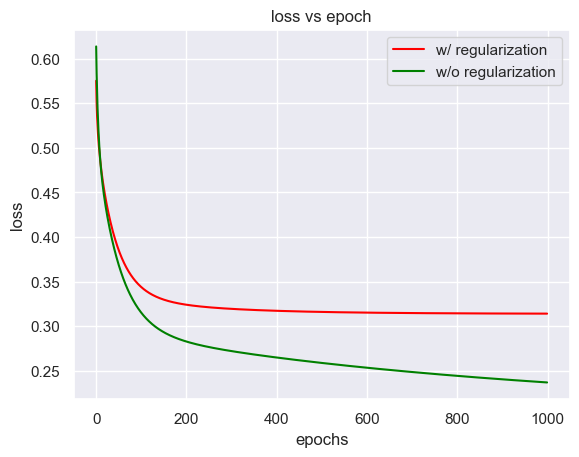

In [38]:
# loss v epoch w & w/o reg
plt.plot(range(epochs), losses_with_l2, label='w/ regularization', color="red")
plt.plot(range(epochs), losses_without_l2, label='w/o regularization', color="green")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend()
plt.show()


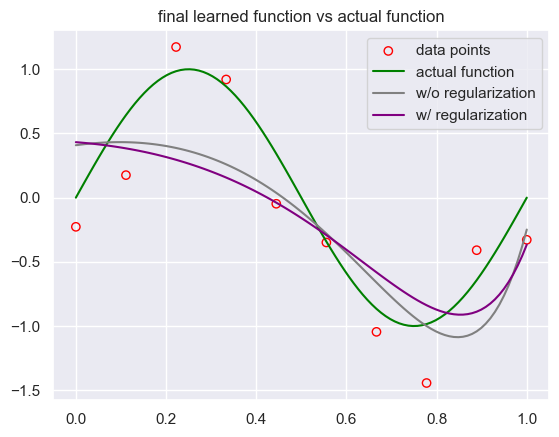

In [39]:
# plotting final hypothesis v actual
y_test_pred_with_l2 = model_with_l2(x_test_expanded).detach()
y_test_pred_without_l2 = model_without_l2(x_test_expanded).detach()

plt.scatter(x_train_data, y_train_data, facecolor="none", color='red', label='data points')
plt.plot(x_test_data, y_test_data, label='actual function', color="green")
plt.plot(x_test_data, y_test_pred_without_l2, label='w/o regularization', color="grey")
plt.plot(x_test_data, y_test_pred_with_l2, label='w/ regularization', color="purple")
plt.legend()
plt.title('final learned function vs actual function')
plt.show()

# **Task 2: Momentum**

In [40]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [41]:
import seaborn as sns

sns.set_theme()

In [42]:
class PolynomialFeature:
    def __init__(self, degree):
        self.degree = degree
    
    def transform(self, X):
        return torch.cat([X ** i for i in range(self.degree + 1)], dim=1)

In [43]:

M = 8
feature = PolynomialFeature(M) 

X_train = feature.transform(x_train_data.unsqueeze(1)) 
X_test = feature.transform(x_test_data.unsqueeze(1))


In [44]:
# mse 
def cal_cost(theta, X, y, alpha=0.01):
    m = y.size(0)
    predictions = X.matmul(theta)
    mse_loss = (1 / (2 * m)) * torch.sum((predictions - y) ** 2)
    reg_loss = (alpha / 2) * torch.sum(theta ** 2)  # Regularization term
    cost = mse_loss + reg_loss
    return cost


In [45]:
# sgd
def sgd(X, y, theta, learning_rate=0.01, iterations=1000, alpha=0.01):
    m = y.size(0)
    cost_history = torch.zeros(iterations)
    
    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = torch.randint(0, m, (1,)).item()  
            x_i = X[rand_ind, :].view(1, -1)  
            y_i = y[rand_ind].view(1) 
            prediction = x_i.matmul(theta)  
            
            gradient = x_i.t().matmul(prediction - y_i) + alpha * theta  # w/ reg
            
            # updating wts
            with torch.no_grad():
                theta -= (learning_rate / m) * gradient
            
            # Accumulate cost
            cost += cal_cost(theta, x_i, y_i, alpha)
        
        cost_history[it] = cost / m  # avg
    
    return theta, cost_history


In [46]:
# sgd w/ mometum
def sgd_momentum(X, y, theta, learning_rate=0.01, iterations=1000, alpha=0.01, momentum=0.9):
    m = y.size(0)
    cost_history = torch.zeros(iterations)
    velocity = torch.zeros_like(theta)
    
    for it in range(iterations):
        cost = 0.0
        for i in range(m):
            rand_ind = torch.randint(0, m, (1,)).item()  
            x_i = X[rand_ind, :].view(1, -1)  
            y_i = y[rand_ind].view(1)  
            prediction = x_i.matmul(theta) 
            
            gradient = x_i.t().matmul(prediction - y_i) + alpha * theta  # w/ reg
            
            # updatin velocity
            velocity = momentum * velocity + (learning_rate / m) * gradient
            
            # updatin theta
            with torch.no_grad():
                theta -= velocity
            
            cost += cal_cost(theta, x_i, y_i, alpha)
        
        cost_history[it] = cost / m  # avg
    
    return theta, cost_history


In [47]:
theta_sgd = torch.randn((X_train.size(1), 1), dtype=torch.float32, requires_grad=True)  # Random initialization
theta_momentum = torch.randn((X_train.size(1), 1), dtype=torch.float32, requires_grad=True)  # Random initialization

In [48]:
learning_rate = 0.01
iterations = 1000
alpha = 0.01
momentum = 0.9
theta_sgd, cost_history_sgd = sgd(X_train, y_train_data, theta_sgd, learning_rate=learning_rate, iterations=iterations, alpha=alpha)
theta_momentum, cost_history_momentum = sgd_momentum(X_train, y_train_data, theta_momentum, learning_rate=learning_rate, iterations=iterations, alpha=alpha, momentum=momentum)


In [49]:
def initialize_theta(X_train):
    return torch.randn((X_train.size(1), 1), dtype=torch.float32)  # Random initialization

In [50]:
alpha = 1e-3 # for reg
theta_reg = initialize_theta(X_train)
theta_reg, cost_history_reg = sgd(X_train, y_train_data, theta_reg, learning_rate=learning_rate, iterations=iterations, alpha=alpha)

X_test = X_test.reshape(-1, theta_reg.shape[0])
y_pred_reg = X_test.matmul(theta_reg)

In [51]:
def moving_average(data, window_size):
    return torch.nn.functional.conv1d(data.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, window_size) / window_size, padding=window_size//2).squeeze()

window_size = 50
loss_history_sgd = moving_average(cost_history_sgd.detach(), window_size)
loss_history_momentum = moving_average(cost_history_momentum.detach(), window_size)

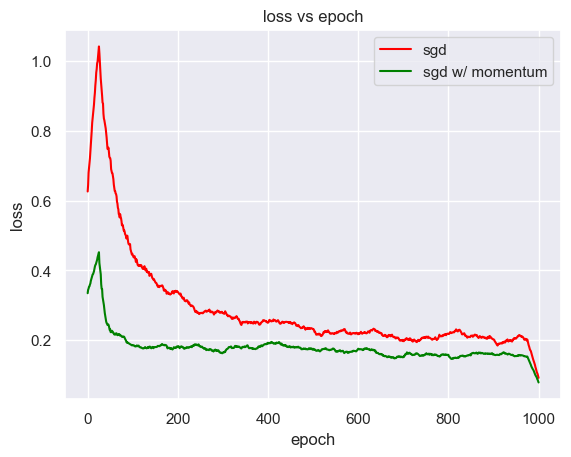

In [52]:
# plotting loss v epoch
plt.plot(loss_history_sgd, label="sgd", color='red')
plt.plot(loss_history_momentum, label="sgd w/ momentum", color='green')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss vs epoch")
plt.legend()
plt.show()


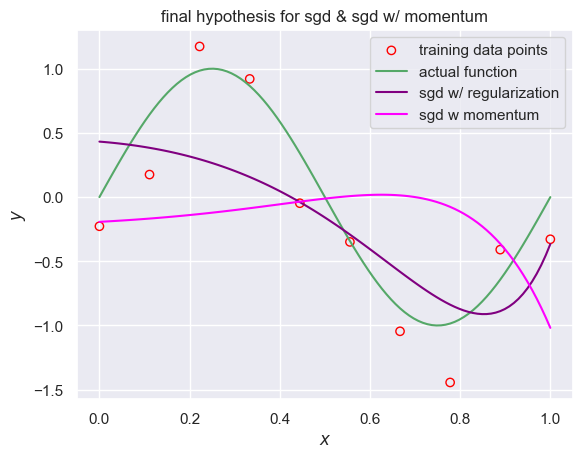

In [55]:
# final plot
plt.scatter(x_train_data.numpy(), y_train_data, facecolor="none", color="red", label="training data points")
plt.plot(x_test_data.numpy(), y_test_data.numpy(), "-g", label="actual function")
plt.plot(x_test_data.numpy(), y_test_pred_with_l2.detach().numpy(), label="sgd w/ regularization", color="purple")
plt.plot(x_test_data.numpy(), y_pred_reg.detach().numpy(), label="sgd w momentum",color='magenta')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("final hypothesis for sgd & sgd w/ momentum")
plt.legend()
plt.show()

### Gradient Descent and Loss Equations

1. **Mean Squared Error (MSE) Loss**:
   $[
   \text{MSE} = \frac{1}{2m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
   $]
   where $( m$\) is the number of samples, $( y_i $) is the true value, and $( \hat{y}_i $) is the predicted value.

2. **Cost Function with Regularization**:
   $[
   J(\theta) = \text{MSE} + \frac{\alpha}{2} \sum_{j=1}^{n} \theta_j^2
   $]
   where $( \alpha $) is the regularization parameter, $( n $) is the number of features, and $( \theta $) are the model parameters.

3. **Gradient Update Rule**:
   $[
   \theta := \theta - \frac{\eta}{m} \nabla J(\theta)
   $]
   where $( \eta $) is the learning rate and $( \nabla J(\theta) $) is the gradient of the cost function with respect to $( \theta $).

4. **Gradient with Regularization**:
   $[
   \nabla J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i)x_i + \alpha \theta
   $]
   where $( h_\theta(x_i) $) is the hypothesis function.

### Hyperparameters Used

- **Learning Rate** ($(\eta$)): $(0.01$)
- **Iterations**: $(1000$)
- **Regularization Parameter** ($(\alpha$)):
  - For SGD with regularization: $(0.01$)
  - For SGD without regularization: $(0.0$)
  - For SGD with a small regularization term: $(1 \times 10^{-3}$)
- **Momentum**: $(0.9$) (used only in SGD with Momentum)
- **Window Size** for Moving Average Smoothing: $(50$)
